## 0-Librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import BatchNormalization, RandomRotation, RandomTranslation, RandomZoom, RandomBrightness
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.config import run_functions_eagerly

2025-09-19 11:38:14.457766: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-19 11:38:15.195909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-19 11:38:19.017508: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
run_functions_eagerly((True))

## 1 - Data Preparation

In [3]:
X_train = np.load("Images/train_images.npy") 
y_train = np.load("Images/train_labels.npy") 
X_test = np.load("Images/test_images.npy")  
y_test = np.load("Images/test_labels.npy")  

In [4]:
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data y_train:{y_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')
print(f'Shape of data y_test:{y_test.shape}')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data y_train:(60000,)

Shape of data X_test:(10000, 28, 28, 1)

Shape of data y_test:(10000,)


In [5]:
# Normalize images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [6]:
# Flatten images for dense model
X_train_flat = X_train.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)

## 2 - Data Viz

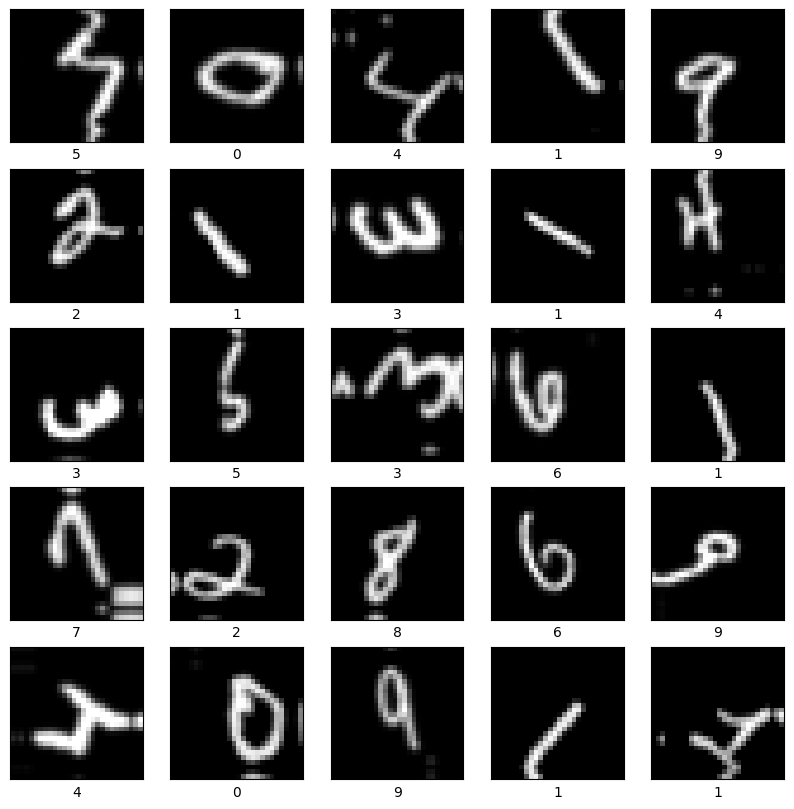

In [7]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.xlabel(y_train[i])
plt.show()

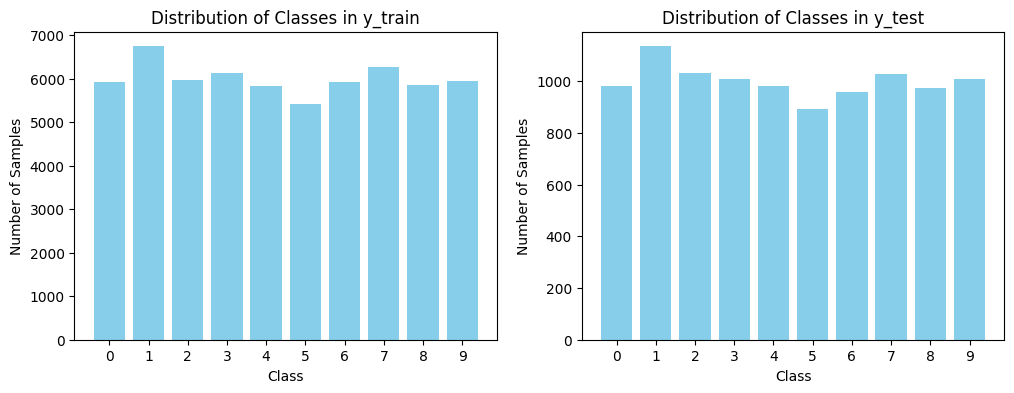

In [8]:
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(unique_classes_train, counts_train, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_train')
plt.xticks(unique_classes_train)  

plt.subplot(1, 2, 2)
plt.bar(unique_classes_test, counts_test, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_test')
plt.xticks(unique_classes_test)  
plt.show()

## 3 - Dense Modele

### Parameters

In [ ]:
# Parameters
epochs_dense =  30
batch_size_dense = 128
validation_split_dense = .2
k_folds_dense = 5
learning_rate_dense = 0.001
metric_dense = "accuracy"  # "SparseCategoricalAccuracy"
monitor_callback_cnn = "val_accuracy"
patience_callback_cnn = 5

### Modele

In [10]:
def create_dense_model():
    dense_model = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

    dense_model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate_dense),
                    loss='sparse_categorical_crossentropy',
                    metrics=[metric_dense]
        )
    return dense_model

In [ ]:
skf = StratifiedKFold(n_splits=k_folds_dense, shuffle=True)
fold_results = []
best_cnn_model = None
best_accuracy = 0.0
best_cnn_history = None
#histories_dense = []
best_fold = None

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_flat, y_train)):
    print(f"\nFold {fold + 1}/{k_folds_dense}")


    X_train_fold, X_val_fold = X_train_flat[train_idx], X_train_flat[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # New model for the current fold
    dense_model = create_dense_model()

    # Train the model
    history = dense_model.fit(
        X_train_fold, y_train_fold,
        epochs=epochs_dense,
        batch_size=batch_size_dense,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[ EarlyStopping(monitor=monitor_callback_cnn, patience=patience_callback_cnn, restore_best_weights=True)],
        verbose=1
    )

    #histories_dense.append(history)

    # Evaluate the model
    val_loss, val_accuracy = dense_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for fold {fold + 1}: {val_accuracy:.4f}")

    # Store the results
    fold_results.append(val_accuracy)

    # Kepp the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_dense_model = dense_model
        best_dense_history = history
        best_fold = fold

# Print the result
print("\nCross-validation results:")
for i, accuracy in enumerate(fold_results):
    print(f"Fold {i + 1}: Validation accuracy = {accuracy:.4f}")

print(f"\nBest validation accuracy: {best_accuracy:.4f}")

# Retourner le meilleur modèle
print("\nBest model summary:")
best_dense_model.summary()


Fold 1/5


/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1758274703.594172   51171 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1758274703.709091   51171 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/hbreton/Projets/2-Projets_co

Epoch 1/30


2025-09-19 11:38:24.037250: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 150528000 exceeds 10% of free system memory.


375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - accuracy: 0.1751 - loss: 2.2242 - val_accuracy: 0.2332 - val_loss: 2.1234
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.2482 - loss: 2.0744 - val_accuracy: 0.2705 - val_loss: 2.0209
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.2807 - loss: 1.9963 - val_accuracy: 0.3064 - val_loss: 1.9493
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.3069 - loss: 1.9326 - val_accuracy: 0.3316 - val_loss: 1.8806
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.3345 - loss: 1.8607 - val_accuracy: 0.3708 - val_loss: 1.7875
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.3641 - loss: 1.7912 - val_accuracy: 0.4004 - val_loss: 1.7084
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.3869 - loss: 1.7371 - val_accuracy: 0.4287 - val_loss: 1.6540
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.4043 - loss: 1.6892 - val_accurac

2025-09-19 11:49:55.228198: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 150528000 exceeds 10% of free system memory.


375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.1683 - loss: 2.2325 - val_accuracy: 0.2067 - val_loss: 2.1459
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.2361 - loss: 2.0999 - val_accuracy: 0.2592 - val_loss: 2.0396
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.2693 - loss: 2.0208 - val_accuracy: 0.2867 - val_loss: 1.9748
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.2954 - loss: 1.9629 - val_accuracy: 0.3218 - val_loss: 1.9153
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.3268 - loss: 1.8906 - val_accuracy: 0.3542 - val_loss: 1.8259
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.3547 - loss: 1.8134 - val_accuracy: 0.3870 - val_loss: 1.7395
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.3782 - loss: 1.7556 - val_accuracy: 0.4053 - val_loss: 1.7067
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.3980 - loss: 1.7089 - val_accurac

2025-09-19 12:01:54.801315: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 150528000 exceeds 10% of free system memory.


375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - accuracy: 0.1651 - loss: 2.2374 - val_accuracy: 0.2153 - val_loss: 2.1422
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.2350 - loss: 2.1064 - val_accuracy: 0.2583 - val_loss: 2.0431
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.2743 - loss: 2.0214 - val_accuracy: 0.2985 - val_loss: 1.9582
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.3039 - loss: 1.9476 - val_accuracy: 0.3258 - val_loss: 1.8841
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.3320 - loss: 1.8761 - val_accuracy: 0.3629 - val_loss: 1.7913
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.3575 - loss: 1.8091 - val_accuracy: 0.3919 - val_loss: 1.7178
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.3794 - loss: 1.7538 - val_accuracy: 0.4275 - val_loss: 1.6566
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.3969 - loss: 1.7094 - val_accurac

### Results

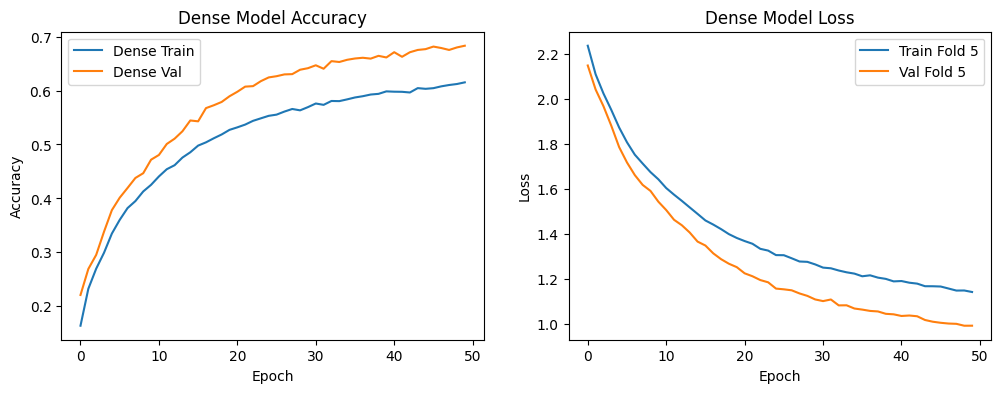

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_dense_history.history[metric_dense], label='Dense Train')
plt.plot(best_dense_history.history['val_' + metric_dense], label='Dense Val')
plt.title('Dense Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(best_dense_history.history['loss'], label=f'Train Fold {i+1}')
plt.plot(best_dense_history.history['val_loss'], label=f'Val Fold {i+1}')
plt.title('Dense Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Predict classes using the dense model
y_pred_dense = best_dense_model.predict(X_test_flat)
y_pred_classes_dense = np.argmax(y_pred_dense, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


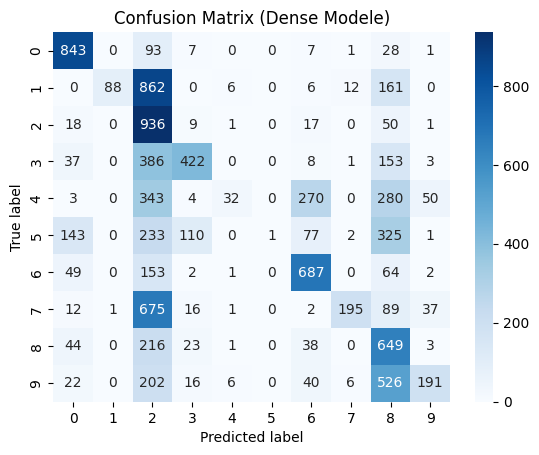

Class 0:
  Sensitivity (SEV): 0.8602
  Specificity (SPE): 0.9636

  Accuracy: 0.9535
  F1-score: 0.7838

Class 1:
  Sensitivity (SEV): 0.0775
  Specificity (SPE): 0.9999

  Accuracy: 0.8952
  F1-score: 0.1438

Class 2:
  Sensitivity (SEV): 0.9070
  Specificity (SPE): 0.6473

  Accuracy: 0.6741
  F1-score: 0.3648

Class 3:
  Sensitivity (SEV): 0.4178
  Specificity (SPE): 0.9792

  Accuracy: 0.9225
  F1-score: 0.5213

Class 4:
  Sensitivity (SEV): 0.0326
  Specificity (SPE): 0.9982

  Accuracy: 0.9034
  F1-score: 0.0621

Class 5:
  Sensitivity (SEV): 0.0011
  Specificity (SPE): 1.0000

  Accuracy: 0.9109
  F1-score: 0.0022

Class 6:
  Sensitivity (SEV): 0.7171
  Specificity (SPE): 0.9486

  Accuracy: 0.9264
  F1-score: 0.6512

Class 7:
  Sensitivity (SEV): 0.1897
  Specificity (SPE): 0.9975

  Accuracy: 0.9145
  F1-score: 0.3133

Class 8:
  Sensitivity (SEV): 0.6663
  Specificity (SPE): 0.8143

  Accuracy: 0.7999
  F1-score: 0.3935

Class 9:
  Sensitivity (SEV): 0.1893
  Specificity (SPE

In [ ]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes_dense)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)

# Plot confusion matrix
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Dense Modele)')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    accuracy = (tn + tp) / (tp + fn + tn + fp)
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}\n')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-score: {f1:.4f}\n')

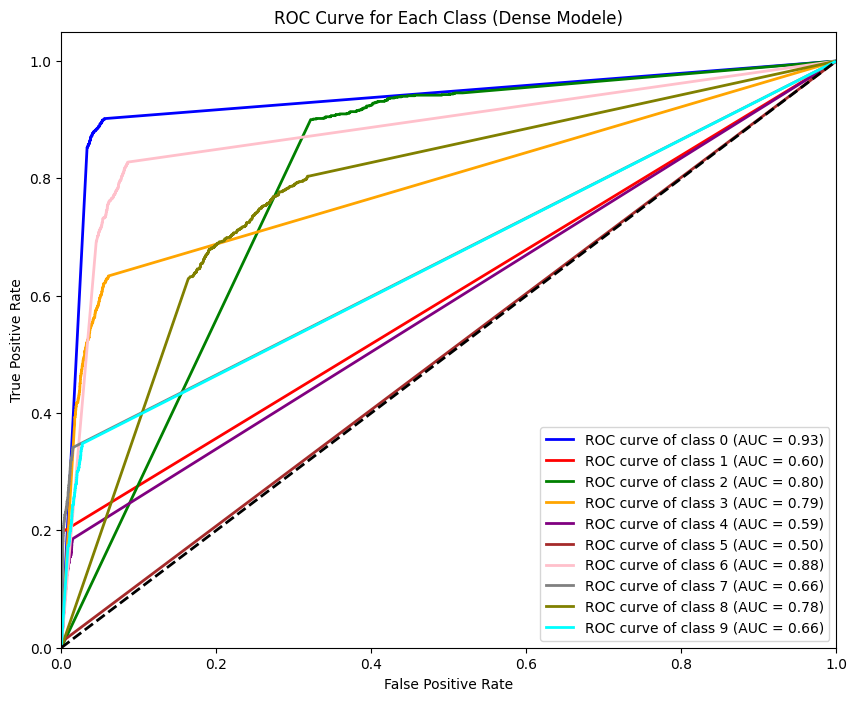

In [ ]:
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_dense[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (Dense Modele)')
plt.legend(loc="lower right")
plt.show()